In [82]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

In [83]:
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

def compute_spread(p1, p2, tf, x):
    data1 = get_rates(p1, tf, x)
    data2 = get_rates(p2, tf, x)
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


# Mean Reversion Based

<Axes: xlabel='time'>

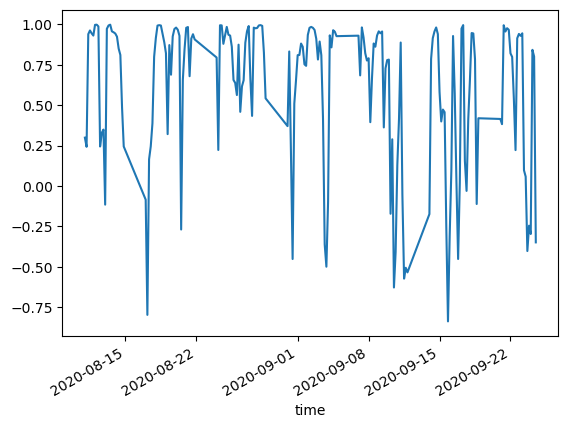

In [84]:
EURUSD = get_rates('EURUSD.a', mt5.TIMEFRAME_H4, 5000)
GBPUSD = get_rates('GBPUSD.a', mt5.TIMEFRAME_H4, 5000)

combined_df = pd.concat([EURUSD['close'].rename('EURUSD_close'),
                         GBPUSD['close'].rename('GBPUSD_close')], axis=1)

window_size = 5  # Change this to the size of the window you want
combined_df['rolling_corr'] = combined_df['EURUSD_close'].rolling(window=window_size).corr(combined_df['GBPUSD_close'])
combined_df['rolling_corr'].iloc[0:200].plot()

In [86]:
combined_df['EURUSD_return'] = combined_df['EURUSD_close'].pct_change()
combined_df['GBPUSD_return'] = combined_df['GBPUSD_close'].pct_change()
combined_df['diff'] = combined_df['EURUSD_return'] - combined_df['GBPUSD_return']
combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
adf_test(combined_df['rolling_corr_returns'].dropna())

{'ADF Statistic': -24.206033973391445,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4316624715142177,
  '5%': -2.862119970102166,
  '10%': -2.5670787188546584}}

<Axes: xlabel='time'>

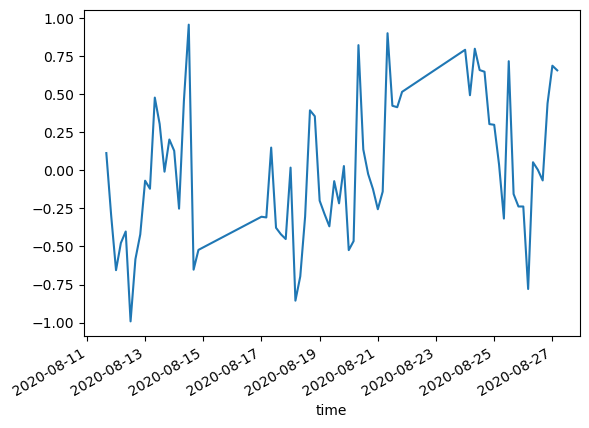

In [90]:
combined_df['rolling_corr_returns'].iloc[8:78].plot()